### Описание задачи

Целью работы является предсказание стоимости квартиры

### Описание датасета

    Id - идентификационный номер квартиры
    DistrictId - идентификационный номер района
    Rooms - количество комнат
    Square - площадь
    LifeSquare - жилая площадь
    KitchenSquare - площадь кухни
    Floor - этаж
    HouseFloor - количество этажей в доме
    HouseYear - год постройки дома
    Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
    Social_1, Social_2, Social_3 - социальные показатели местности
    Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
    Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
    Price - цена квартиры

### Загрузка и анализ данных

In [257]:
import numpy as np
import pandas as pd
import pickle

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, KFold, GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error as mse, r2_score as r2

In [258]:
import warnings
warnings.filterwarnings('ignore')

In [259]:
matplotlib.rcParams.update({'font.size': 14})

In [260]:
TRAIN_DATASET_PATH = './real-estate-price-prediction-moscow/train.csv'
PREPARED_TRAIN_DATASET_PATH = './real-estate-price-prediction-moscow/prepared_train.csv'
TEST_DATASET_PATH = './real-estate-price-prediction-moscow/test.csv'

In [261]:
train_df = pd.read_csv(TRAIN_DATASET_PATH, sep=',')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [262]:
train_df.shape

(10000, 20)

In [263]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

Датафрейм содержит 10000 наблюдений по 20 признакам, три из которых категориальные, а остальные количественные.

DistrictId по типу является количественным, но на самом деле категориальный.

В двух переменных LifeSquare и Healthcare_1 содержатся пропуски.

Тестовый датафрейм:

In [264]:
test_df = pd.read_csv(TEST_DATASET_PATH, sep=',')
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


In [265]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [266]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

test_df['Id'] = test_df['Id'].astype(str)
test_df['DistrictId'] = test_df['DistrictId'].astype(str)

##### Количественные признаки:

In [267]:
train_df_num_features = train_df.select_dtypes(include=['float64', 'int64'])
train_df_num_features.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
0,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,11,3097,0,NaN,0,0,305018.871089
1,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,30,6207,1,1183.0,1,0,177734.553407
2,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,33,5261,0,240.0,3,1,282078.720850
3,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,1,264,0,NaN,0,1,168106.007630
4,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,33,8667,2,NaN,0,6,343995.102962


In [268]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


Rooms - min и max выглядят не реалистично, понятно, что в квартире должна быть минимум одна комната, а 19-тикомнатная квартира хоть и может существовать, но таких квартир в Москве - единицы

Square, LifeSquare, KitchenSquare - min и max выглядят не реалистично

HouseFloor - min и max выглядят не реалистично, на самом деле минимально один (хотя для Москвы это странно), а максимально - 95 (это этажность самого высокого дома в Москве)

##### Категориальные признаки:

In [269]:
train_df_obj_features = train_df.select_dtypes(include='object')
train_df_obj_features.head()

,Id,DistrictId,Ecology_2,Ecology_3,Shops_2
0,11809,27,B,B,B
1,3013,22,B,B,B
2,8215,1,B,B,B
3,2352,1,B,B,B
4,13866,94,B,B,B


In [270]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

In [271]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [272]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

Категориальные признаки содержат два значения В и А


### EDA и очистка данных

###### Распределение таргета


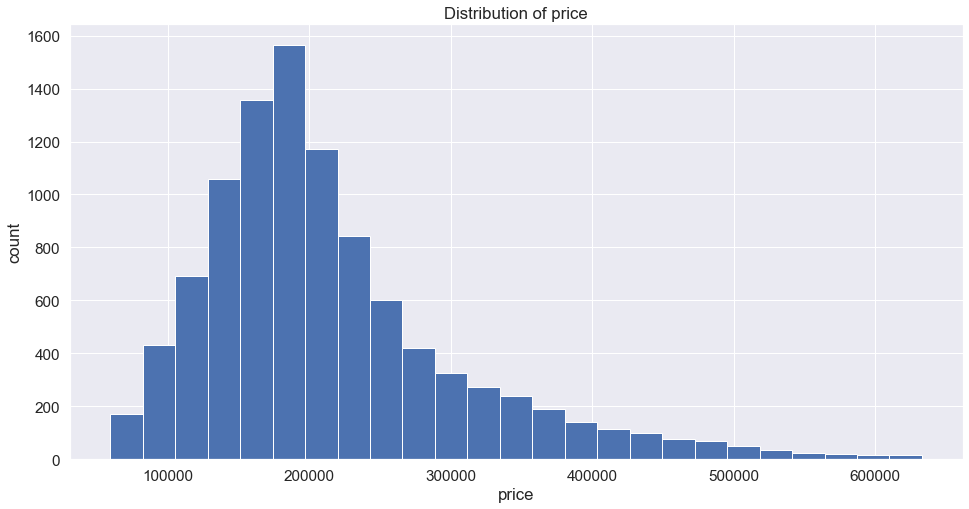

In [273]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=25)
plt.ylabel('count')
plt.xlabel('price')

plt.title('Distribution of price')
plt.show()

In [274]:
target_mean = round(train_df['Price'].mean(), 2)
target_median = train_df['Price'].median()
target_mode = train_df['Price'].mode()[0]

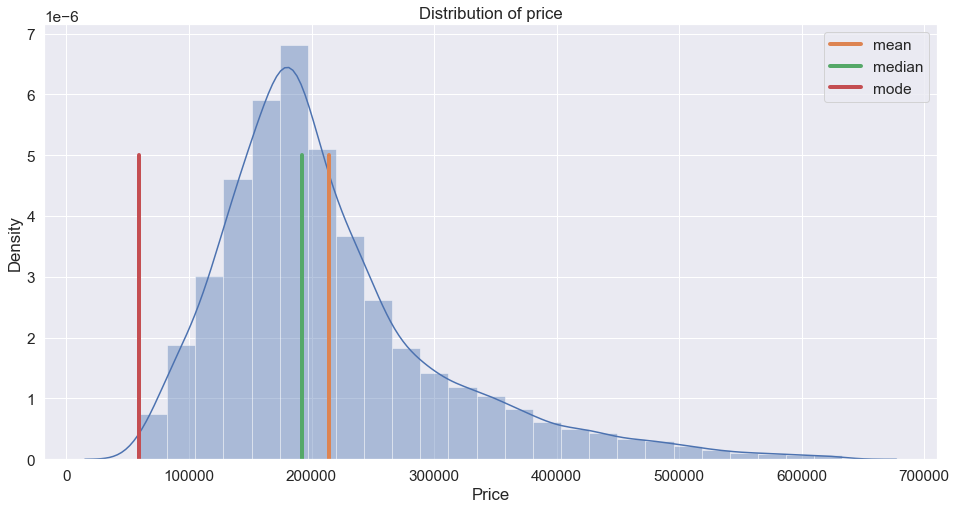

In [275]:
plt.figure(figsize = (16, 8))

sns.distplot(train_df['Price'], bins=25)

y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label='mean',  linewidth=4)
plt.plot([target_median] * 10, y, label='median',  linewidth=4)
plt.plot([target_mode] * 10, y, label='mode', linewidth=4)

plt.title('Distribution of price')
plt.legend()
plt.show()

Целевая переменная выглядит корректно, наблюдается логромальное распредение. Среднее арифметическое, медиана и мода расположены около значения 200000

##### Распределение фичей

In [276]:
train_df_num_features = train_df.select_dtypes(include=['float64', 'int64'])
train_df_num_features.drop(['Price'], axis=1, inplace=True)
train_df_num_features

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
0,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,11,3097,0,NaN,0,0
1,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,30,6207,1,1183.0,1,0
2,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,33,5261,0,240.0,3,1
3,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,1,264,0,NaN,0,1
4,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,33,8667,2,NaN,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,52,10311,6,NaN,1,9
9996,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,2,629,1,NaN,0,0
9997,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,20,4386,14,NaN,1,5
9998,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,47,8004,3,125.0,3,5


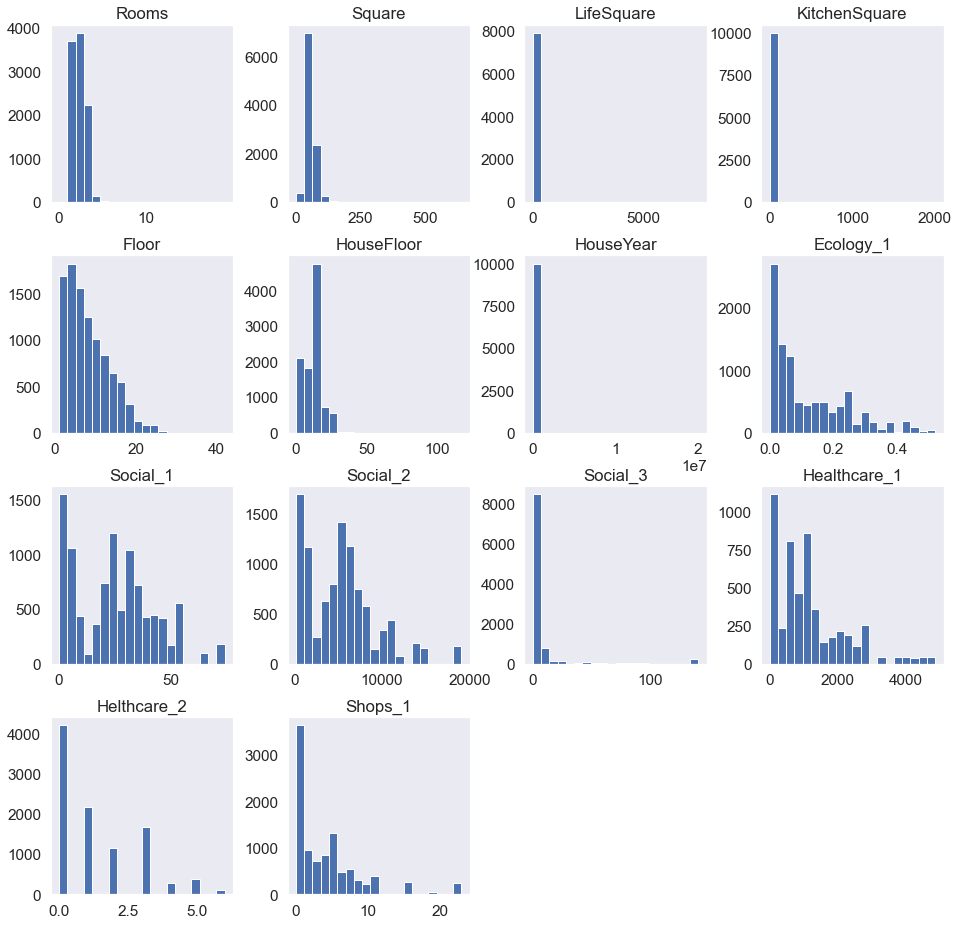

In [277]:
train_df_num_features.hist(figsize=(16,16), bins=20, grid=False);

##### HouseYear fix

In [278]:
train_df['HouseYear'].value_counts().sort_index()

1910          1
1912          2
1914          1
1916          1
1917          3
           ... 
2018        175
2019         79
2020         19
4968          1
20052011      1
Name: HouseYear, Length: 97, dtype: int64

In [279]:
train_df['HouseYear'].unique()

array([    2014,     1966,     1988,     1977,     1972,     1968,
           1986,     2008,     1978,     2012,     1969,     2003,
           1981,     1962,     2015,     2018,     1976,     1985,
           1960,     2019,     1974,     1956,     1963,     1961,
           1979,     2006,     1953,     1973,     1982,     1965,
           2007,     2013,     1983,     1995,     1971,     2017,
           1964,     1991,     1990,     2016,     2011,     1984,
           1993,     1997,     2009,     1975,     2010,     1987,
           1935,     1970,     1967,     1989,     1959,     1996,
           2005,     1994,     1958,     2004,     1998,     1992,
           1980,     2000,     2002,     1954,     2001,     1999,
           1917,     1955,     1957,     1934,     2020,     1932,
           1942,     1940,     1937,     1941,     1939,     1931,
           1951,     1912,     1918,     1952,     1919,     1936,
           1930,     1938,     1950,     1933,     1929,     1

Видно всего два выброса

In [280]:
train_df.loc[train_df['HouseYear'] > 2020]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
8828,11607,147,2.0,44.791836,28.360393,5.0,4,9.0,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B,243028.603096
9163,10814,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B,254084.534396


Замена выбросов на 2000

In [281]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

##### Rooms fix

In [282]:
train_df['Rooms'].value_counts().sort_index()

0.0        8
1.0     3705
2.0     3880
3.0     2235
4.0      150
5.0       18
6.0        1
10.0       2
19.0       1
Name: Rooms, dtype: int64

Основываясь на данных с циана, удалось выяснить, что самая большая квартира в Москве - 6тикомнатная

In [283]:
train_df[(train_df['Rooms'] == 0) | (train_df['Rooms'] > 6)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2004,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,B,B,74,19083,2,NaN,5,15,B,317265.323792
2194,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,B,B,43,8429,3,NaN,3,9,B,158998.110646
2728,14865,9,10.0,60.871266,38.420681,10.0,3,2.0,1994,0.161532,B,B,25,5648,1,30.0,2,4,B,172329.270863
3780,7317,27,0.0,41.790881,NaN,0.0,13,0.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,98129.976788
5894,770,28,0.0,49.483501,NaN,0.0,16,0.0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.338463
6088,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,B,B,1,264,0,NaN,0,1,B,78364.616704
6401,9443,27,0.0,87.762616,85.125471,0.0,5,15.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,219281.918007
7644,7917,27,0.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.260887
7929,456,6,0.0,81.491446,NaN,0.0,4,0.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.799112
9767,12638,27,0.0,138.427694,136.215499,0.0,4,3.0,2016,0.075424,B,B,11,3097,0,NaN,0,0,B,268394.744389


Видно, что выбросов по признаку Rooms не много

Замена на медиану

In [284]:
train_df['Rooms'].median()

2.0

In [285]:
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] > 6), 'Rooms'] = train_df['Rooms'].median()

##### HouseFloor fix

Самое высокое здание в Москве в сити имеет 95 этажей

In [286]:
train_df[train_df['HouseFloor'] > 95]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
746,9300,74,2.0,71.747869,74.579809,9.0,5,99.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,243329.912579
1678,78,30,2.0,65.773749,66.811789,1.0,8,117.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B,207248.370520
4657,10806,5,1.0,51.944587,48.709601,1.0,6,99.0,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B,296127.115515


In [287]:
train_df['HouseFloor'].value_counts().sort_index().head(5)

0.0    269
1.0    497
2.0     48
3.0    127
4.0    134
Name: HouseFloor, dtype: int64

Замена на медиану всех значений <=1 и >95

In [288]:
train_df['HouseFloor'].median()

13.0

In [289]:
train_df.loc[(train_df['HouseFloor'] <= 1) | (train_df['HouseFloor'] > 95), 'HouseFloor'] = train_df['HouseFloor'].median()

##### Floor fix

Важно обработать выбросы, где переменная Floor больше HouseFloor

In [290]:
train_df.loc[train_df['Floor'] > train_df['HouseFloor']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
17,1190,8,2.0,49.396000,28.299600,5.0,6,5.0,1962,0.458174,B,A,26,4439,1,1130.0,1,5,B,186971.926566
19,367,45,1.0,42.367289,40.012529,1.0,16,14.0,2015,0.195781,B,B,23,5212,6,NaN,3,2,B,250466.980777
21,8471,20,3.0,75.611065,47.494621,8.0,11,9.0,1976,0.019509,B,B,37,7687,11,176.0,5,5,B,366916.246494
25,4521,6,2.0,65.409965,NaN,1.0,18,13.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,191205.272608
33,847,74,2.0,73.314975,74.131261,1.0,7,6.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,254005.381863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9953,7659,57,1.0,38.485252,22.550608,8.0,19,17.0,1992,0.133215,B,B,49,11395,3,1406.0,3,4,A,183485.284995
9960,16258,48,3.0,96.056784,98.152802,1.0,15,13.0,2017,0.041125,B,B,46,9515,5,NaN,1,10,B,524365.550705
9968,9920,1,3.0,86.487550,NaN,1.0,18,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,248248.935528
9970,13501,6,1.0,41.310416,19.117077,9.0,18,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,114878.830713


Замена выбросов на минимальное значение признака HouseFloor

In [291]:
train_df['HouseFloor'].min()

2.0

In [292]:
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'Floor'] = train_df['HouseFloor'].min()

##### Square fix

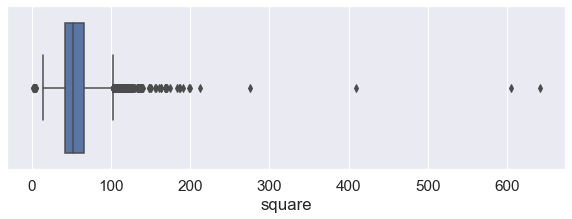

In [293]:
plt.figure(figsize=(10, 3))

sns.boxplot(train_df['Square'])

plt.xlabel('square')
plt.show()

Считаем, что все, что больше 200 - выбросы, хотя самая большая квартира в Москве имеет площадь 2200 кв.м

In [294]:
train_df.loc[train_df['Square'] > 200]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
726,28,9,2.0,604.705972,NaN,1.0,17,18.0,1977,0.161532,B,B,25,5648,1,30.0,2,4,B,187717.242538
1776,16568,27,4.0,200.334539,201.627361,25.0,1,2.0,2013,0.041116,B,B,53,14892,4,NaN,1,4,B,528560.506016
1906,5548,86,5.0,275.645284,233.949309,26.0,12,37.0,2011,0.161976,B,A,31,7010,5,4508.0,3,7,B,455264.882666
7010,2307,102,1.0,409.425181,410.639749,10.0,4,4.0,2016,0.238617,B,B,26,3889,6,705.0,3,6,B,90470.430830
7644,7917,27,2.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.260887
9229,11602,30,2.0,641.065193,638.163193,10.0,2,19.0,2019,0.000078,B,B,22,6398,141,1046.0,3,23,B,133529.681562


По данным с циана минимальная площадь комнаты = 8 кв.м

In [295]:
train_df.loc[train_df['Square'] < 8].describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.00000,12.000000,3.000000,12.000000,12.000000,12.000000
mean,1.500000,3.700918,18.654549,0.833333,3.583333,15.166667,1986.333333,0.109503,15.083333,3399.25000,1.583333,1234.333333,0.916667,3.166667,267628.420517
std,0.797724,1.414591,27.945305,0.389249,2.874918,5.373899,16.897194,0.090977,16.913998,4008.83046,2.151462,1219.982104,1.505042,3.857303,152024.474252
min,1.000000,1.136859,0.873147,0.000000,1.000000,4.000000,1977.000000,0.007122,1.000000,264.00000,0.000000,520.000000,0.000000,0.000000,97560.720383
25%,1.000000,2.541575,4.054856,1.000000,2.000000,13.000000,1977.000000,0.016149,3.500000,803.50000,0.000000,530.000000,0.000000,0.750000,134847.436543
50%,1.000000,4.385528,4.937913,1.000000,2.500000,13.000000,1977.000000,0.098565,9.000000,1892.00000,0.000000,540.000000,0.000000,1.000000,209575.753425
75%,2.000000,4.681044,14.409538,1.000000,3.750000,17.500000,1986.000000,0.199686,17.750000,3877.75000,3.250000,1591.500000,1.500000,5.500000,418884.612154
max,3.000000,5.497061,79.767964,1.000000,10.000000,25.000000,2016.000000,0.243205,53.000000,13670.00000,6.000000,2643.000000,4.000000,11.000000,483283.488083


Замена на медиану всех значений больше 200 и меньше 8

In [296]:
square_median = round(train_df['Square'].median(), 6)
square_median

52.51331

In [297]:
train_df.loc[(train_df['Square'] > 200) | (train_df['Square'] < 8), 'Square'] = square_median

##### Square и LifeSquare Fix

In [298]:
train_df.loc[train_df['Square'] < train_df['LifeSquare']].describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,477.000000,477.000000,477.000000,477.000000,477.000000,477.000000,477.000000,477.000000,477.000000,477.000000,477.000000,168.000000,477.000000,477.000000,477.000000
mean,1.790356,58.760316,80.492773,3.865828,7.905660,15.218029,1999.968553,0.103003,14.815514,3408.941300,9.643606,882.934524,0.870021,3.545073,199079.749758
std,0.821246,22.331194,342.522322,8.960395,5.847997,5.865317,19.686862,0.111866,16.431790,3770.836568,31.548596,689.628140,1.396229,5.526156,97390.980798
min,1.000000,13.784865,15.988889,0.000000,1.000000,2.000000,1958.000000,0.000000,0.000000,168.000000,0.000000,30.000000,0.000000,0.000000,66630.740772
25%,1.000000,41.022588,42.447936,1.000000,3.000000,12.000000,1977.000000,0.011654,2.000000,629.000000,0.000000,540.000000,0.000000,0.000000,133193.851325
50%,2.000000,53.828610,56.660550,1.000000,6.000000,17.000000,2015.000000,0.072158,6.000000,1564.000000,1.000000,705.000000,0.000000,1.000000,177838.382377
75%,2.000000,70.566571,74.858927,6.000000,12.000000,17.000000,2017.000000,0.195781,24.000000,5735.000000,3.000000,1046.000000,2.000000,5.000000,233719.932275
max,5.000000,174.649522,7480.592129,123.000000,28.000000,37.000000,2020.000000,0.486246,74.000000,19083.000000,141.000000,4508.000000,6.000000,23.000000,621002.912679


График зависимости Square и LifeSquare

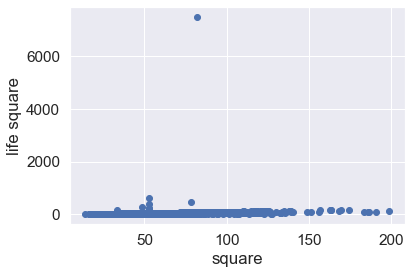

In [299]:
plt.scatter(train_df['Square'], train_df['LifeSquare'])
plt.xlabel('square')
plt.ylabel('life square')
plt.show()

Т.к. ранее выбросы для Square больше 200 были заменены на медиану, используется такое же значение для LifeSquare и замена выбросов на медиану

In [300]:
train_df.loc[train_df['LifeSquare'] > 200].describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,8.00000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,4.000000,8.000000,8.000000,8.000000
mean,2.75000,58.846271,1237.651063,10.875000,5.500000,12.875000,2006.625000,0.097974,25.125000,5900.500000,20.000000,2139.750000,1.375000,6.250000,282928.473270
std,1.28174,13.091963,2527.090426,9.862447,4.720775,11.969455,15.417407,0.092736,19.657332,5072.741862,48.943116,1721.344896,1.407886,7.285014,163174.951294
min,1.00000,48.449873,201.627361,0.000000,1.000000,2.000000,1972.000000,0.000078,2.000000,469.000000,0.000000,705.000000,0.000000,0.000000,90470.430830
25%,2.00000,52.513310,228.269763,4.000000,2.000000,3.750000,2005.500000,0.032295,8.250000,1778.250000,0.750000,960.750000,0.000000,1.750000,139717.594283
50%,2.50000,52.513310,337.090885,10.000000,3.000000,10.500000,2012.000000,0.058448,24.000000,5143.500000,3.500000,1673.000000,1.000000,5.000000,259784.376627
75%,3.25000,58.899815,505.638509,13.750000,9.750000,17.500000,2016.000000,0.174332,36.250000,8061.750000,5.250000,2852.000000,3.000000,7.000000,409506.195650
max,5.00000,81.694417,7480.592129,26.000000,12.000000,37.000000,2019.000000,0.238617,53.000000,14892.000000,141.000000,4508.000000,3.000000,23.000000,528560.506016


In [301]:
lifesquare_median = round(train_df['LifeSquare'].median(), 6)
lifesquare_median

32.78126

In [302]:
train_df.loc[train_df['LifeSquare'] > 200, 'LifeSquare'] = lifesquare_median

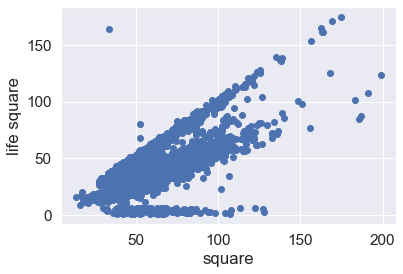

In [303]:
plt.scatter(train_df['Square'], train_df['LifeSquare'])
plt.xlabel('square')
plt.ylabel('life square')
plt.show()

Поиск доли жилой площади от общей, замена выбросов

In [304]:
square_mean_values = train_df[['Square', 'LifeSquare']].dropna().mean()
square_coeff = square_mean_values[1] / square_mean_values[0]
square_coeff

0.6526973510749122

In [305]:
train_df.loc[train_df['LifeSquare'] > train_df['Square'], 'LifeSquare'] = train_df['Square'] * square_coeff

##### Square и KitchenSquare

Почти аналогично поступаем с признаком KitchenSquare

In [306]:
train_df.loc[train_df['Square'] < train_df['KitchenSquare']].describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,4.0,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.00,1.0,4.000000,4.0,4.000000
mean,1.0,38.917333,26.041689,1035.250000,5.750000,13.250000,2003.750000,0.062034,14.250000,3140.000000,0.25,645.0,1.750000,1.5,118361.258541
std,0.0,6.117388,13.610414,1104.914891,2.362908,2.872281,18.518009,0.070780,13.524669,2742.872703,0.50,NaN,2.872281,3.0,28350.812420
min,1.0,32.276663,18.716856,73.000000,4.000000,10.000000,1977.000000,0.006076,2.000000,629.000000,0.00,645.0,0.000000,0.0,99079.960518
25%,1.0,36.622935,19.138010,81.250000,4.000000,12.250000,1998.750000,0.010260,3.500000,843.500000,0.00,645.0,0.000000,0.0,103924.657336
50%,1.0,38.145975,19.500971,1027.000000,5.000000,13.000000,2010.000000,0.041906,12.500000,3100.000000,0.00,645.0,0.500000,0.0,106938.520241
75%,1.0,40.440373,26.404651,1981.000000,6.750000,14.000000,2015.000000,0.093680,23.250000,5396.500000,0.25,645.0,2.250000,1.5,121375.121446
max,1.0,47.100719,46.447960,2014.000000,9.000000,17.000000,2018.000000,0.158249,30.000000,5731.000000,1.00,645.0,6.000000,6.0,160488.033165


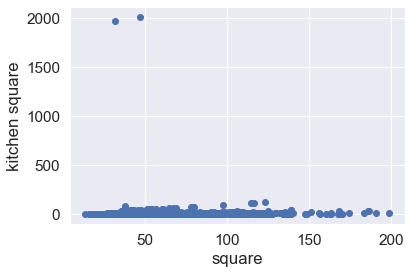

In [307]:
plt.scatter(train_df['Square'], train_df['KitchenSquare'])
plt.xlabel('square')
plt.ylabel('kitchen square')
plt.show()

In [308]:
train_df.loc[train_df['KitchenSquare'] > 50].describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,21.000000,21.000000,20.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,7.000000,21.000000,21.000000,21.000000
mean,2.047619,69.087165,51.266262,256.428571,7.952381,14.666667,2005.714286,0.090262,18.095238,4424.380952,2.619048,1449.571429,1.047619,2.857143,229136.422739
std,0.740013,25.734825,29.494116,577.423724,5.219925,6.421319,16.319139,0.118202,19.183078,4923.598130,5.380299,1271.185910,1.829650,3.863751,104042.056729
min,1.000000,32.276663,2.400832,51.000000,2.000000,2.000000,1977.000000,0.000699,0.000000,168.000000,0.000000,645.000000,0.000000,0.000000,88150.012510
25%,2.000000,53.216778,33.342505,58.000000,4.000000,12.000000,1994.000000,0.017647,2.000000,629.000000,0.000000,697.500000,0.000000,0.000000,160488.033165
50%,2.000000,64.859242,46.797358,72.000000,7.000000,17.000000,2015.000000,0.069753,11.000000,2398.000000,1.000000,900.000000,0.000000,0.000000,212188.959537
75%,3.000000,79.722243,64.330382,96.000000,10.000000,17.000000,2016.000000,0.072158,30.000000,5735.000000,3.000000,1539.000000,1.000000,5.000000,290354.484070
max,3.000000,123.430072,113.109653,2014.000000,22.000000,25.000000,2019.000000,0.437885,53.000000,14892.000000,24.000000,4129.000000,6.000000,11.000000,445074.956552


In [309]:
kitchensquare_median = round(train_df['KitchenSquare'].median(), 6)
kitchensquare_median

6.0

In [310]:
train_df.loc[train_df['KitchenSquare'] > 50, 'KitchenSquare'] = kitchensquare_median

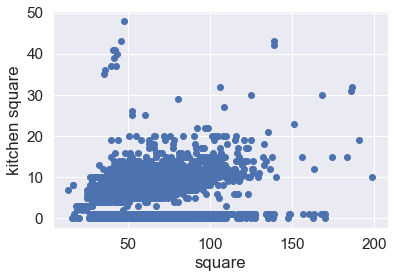

In [311]:
plt.scatter(train_df['Square'], train_df['KitchenSquare'])
plt.xlabel('square')
plt.ylabel('kitchen square')
plt.show()

##### Обрабока пропусков

Обработка пропусков в LifeSquare аналогично выбросам

In [312]:
train_df.loc[train_df['LifeSquare'].isnull(), 'LifeSquare'] = train_df['Square'] * square_coeff

Для признака Healthcare_1 заменяем пропуски на медиану

In [313]:
train_df.loc[train_df['Healthcare_1'].isnull(), 'Healthcare_1'] = train_df['Healthcare_1'].median()

In [314]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  object 
 1   DistrictId     10000 non-null  object 
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     10000 non-null  float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   10000 non-null  float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [315]:
class DataPreprocessing:

    def __init__(self):
        self.means = None
        self.medians = None
    
    def fit(self, X): 
        # Расчет медиан
        self.medians = X.median()
                
        # Расчет минимального значения
        self.min = X.min()
        
    def transform(self, X):
        # Rooms
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] > 6), 'Rooms'] = self.medians['Rooms']
        
        # HouseYear
        X.loc[X['HouseYear'] > 2020, 'HouseYear'] = 2020
        
        # HouseFloor
        X.loc[(X['HouseFloor'] <= 1) | (X['HouseFloor'] > 95), 'HouseFloor'] = self.medians['HouseFloor']
        
        # Floor
        X.loc[X['Floor'] > X['HouseFloor'], 'Floor'] = self.min['HouseFloor']
        
        #Square
        X.loc[(X['Square'] > 200) | (X['Square'] < 8), 'Square'] = self.medians['Square']
        X.loc[X['KitchenSquare'] > 50, 'KitchenSquare'] = self.medians['KitchenSquare']
        X.loc[X['LifeSquare'] > 200, 'LifeSquare'] = self.medians['LifeSquare']
        X.loc[X['LifeSquare'] > X['Square'], 'LifeSquare'] = X['Square'] * 0.6526973510749122
        X.loc[X['LifeSquare'].isnull(), 'LifeSquare'] = X['Square'] * 0.6526973510749122
        
        # Healthcare_1
        X.loc[X['Healthcare_1'].isnull(), 'Healthcare_1'] = self.medians['Healthcare_1']
        
        return X

##### Построение новых признаков

Dummies


In [316]:
train_df['Ecology_2_bin'] = train_df['Ecology_2'].replace({'A':0, 'B':1})
train_df['Ecology_3_bin'] = train_df['Ecology_3'].replace({'A':0, 'B':1})
train_df['Shops_2_bin'] = train_df['Shops_2'].replace({'A':0, 'B':1})

In [317]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  object 
 1   DistrictId     10000 non-null  object 
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     10000 non-null  float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   10000 non-null  float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

DistrictSize/ IsDistrictLarge

In [318]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [319]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize
0,11809,27,3.0,115.027311,75.078021,10.0,4,10.0,2014,0.075424,...,0,900.0,0,0,B,305018.871089,1,1,1,851
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1,1183.0,1,0,B,177734.553407,1,1,1,78
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,0,240.0,3,1,B,282078.720850,1,1,1,652
3,2352,1,1.0,40.409907,26.375439,1.0,10,22.0,1977,0.007122,...,0,900.0,0,1,B,168106.007630,1,1,1,652
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,2,900.0,0,6,B,343995.102962,1,1,1,89


In [320]:
(train_df['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [321]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge
0,11809,27,3.0,115.027311,75.078021,10.0,4,10.0,2014,0.075424,...,900.0,0,0,B,305018.871089,1,1,1,851,1
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1183.0,1,0,B,177734.553407,1,1,1,78,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,240.0,3,1,B,282078.720850,1,1,1,652,1
3,2352,1,1.0,40.409907,26.375439,1.0,10,22.0,1977,0.007122,...,900.0,0,1,B,168106.007630,1,1,1,652,1
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,900.0,0,6,B,343995.102962,1,1,1,89,0


In [322]:
train_df.groupby(["IsDistrictLarge"])["Price"].mean()

IsDistrictLarge
0    245930.782949
1    183212.444913
Name: Price, dtype: float64

In [323]:
class FeatureGenerator:
    def __init__(self):
        
         self.district_size = None
        
    def fit(self, X):
        
        X = X.copy()
    
    # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
    # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        X['DistrictSize'].fillna(5, inplace=True)
        
        return X

Последний взгляд на фичи

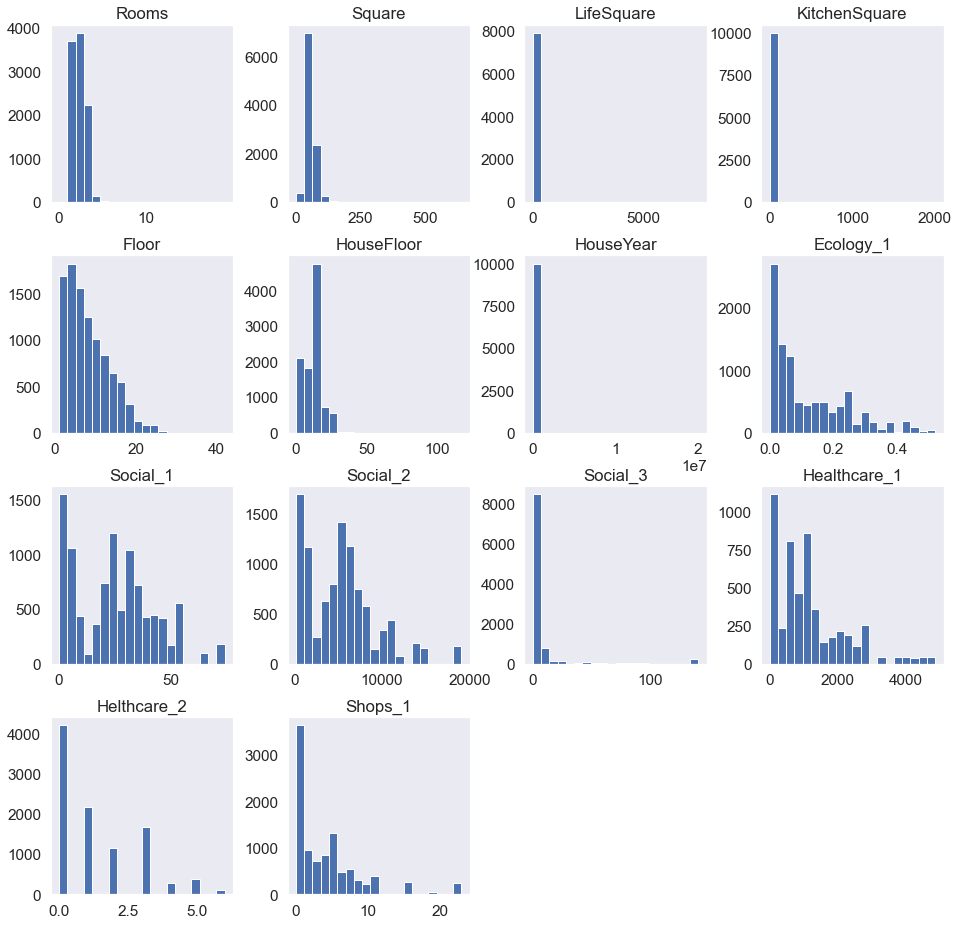

In [324]:
train_df_num_features.hist(figsize=(16,16), bins=20, grid=False);

##### Графики влияния фичей на таргет

Матрица корреляций

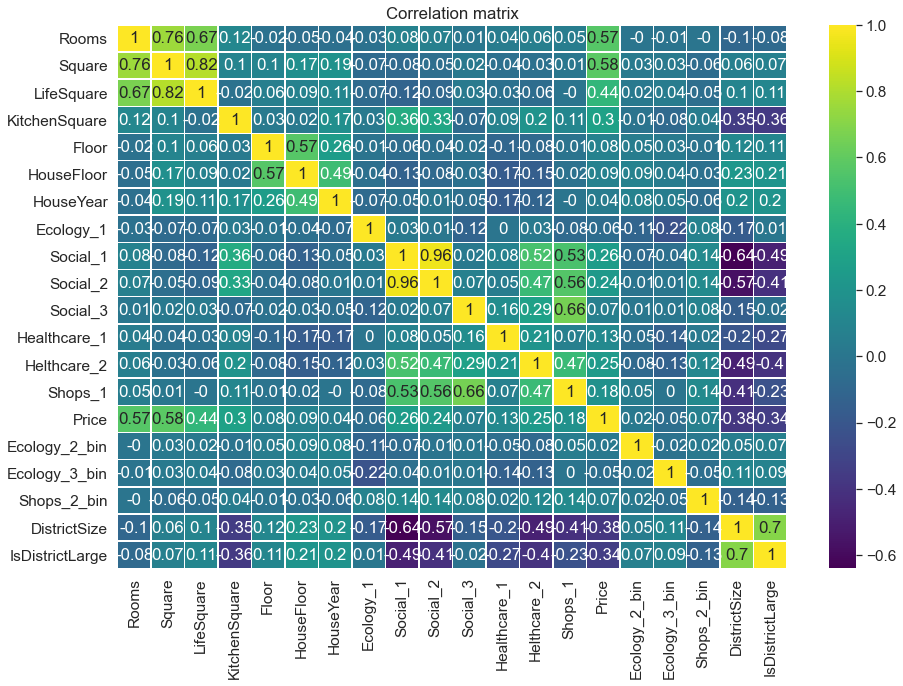

In [325]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
# corr_matrix[np.abs(corr_matrix) < 0.2] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='viridis')

plt.title('Correlation matrix')
plt.show()

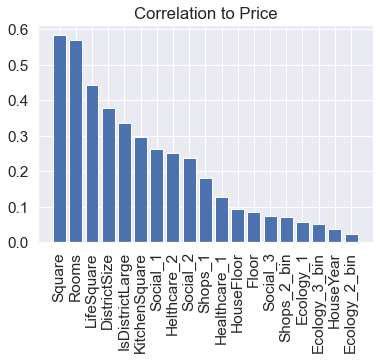

In [326]:
corrmat = train_df.loc[:, train_df.columns != 'Id'].corrwith(
    train_df['Price']).abs().sort_values(ascending=False)[1:]
plt.bar(corrmat.index, corrmat.values)
plt.title('Correlation to Price')
plt.xticks(rotation='vertical')
plt.show()

Преобразование категориальных признаков в количественные ничего не дало. Данные признаки показывают отрицательное или нулевое влияние на таргет. Основные фичи, достойные внимания, это Rooms, Square, LifeSquare, KitchenSquare, Social_1, Social_2, Healthcare_2, Shops_1, DistrictSize, IsDistrictLarge

<AxesSubplot:xlabel='Rooms', ylabel='Price'>

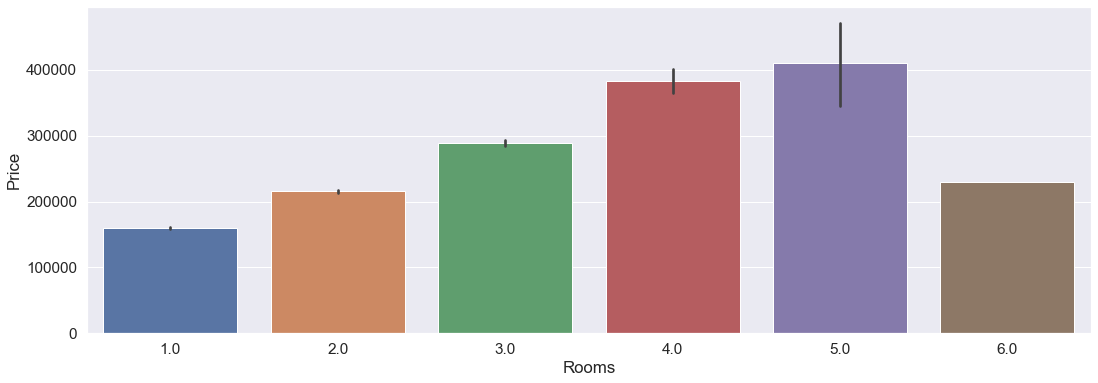

In [327]:
plt.figure(figsize=(18, 6))
sns.barplot(train_df['Rooms'], train_df['Price'])

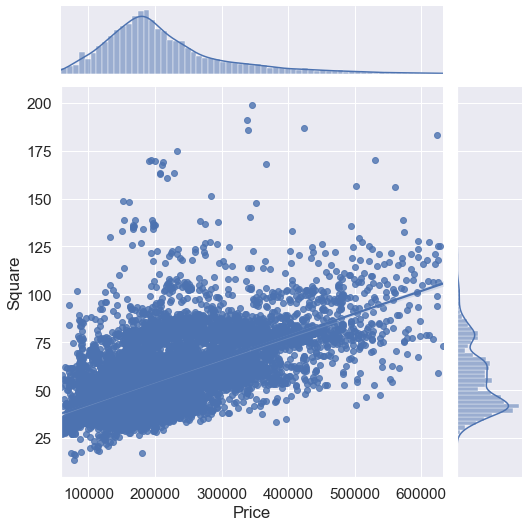

In [328]:
grid = sns.jointplot(train_df['Price'], train_df['Square'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

##### Отбор фич

In [329]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Social_1', 'Social_2', 'Helthcare_2', 'Shops_1']

new_feature_names = ['DistrictSize', 'IsDistrictLarge']

target_name = 'Price'

##### Разбиение на test и train

In [330]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [331]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

In [332]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 19), (3300, 19), (5000, 19))

In [333]:
features_gen = FeatureGenerator()
features_gen.fit(X_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 21), (3300, 21), (5000, 21))

In [334]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [335]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

In [336]:
y_train.head()

8371    288304.774786
5027    203201.637228
9234    271324.195153
3944    200414.401172
6862    120221.581843
Name: Price, dtype: float64

In [337]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

### Построение модели

##### Linear Regression

In [338]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

R2:	0.547
RMSE:	61447.111
MSE:	3775747407.038


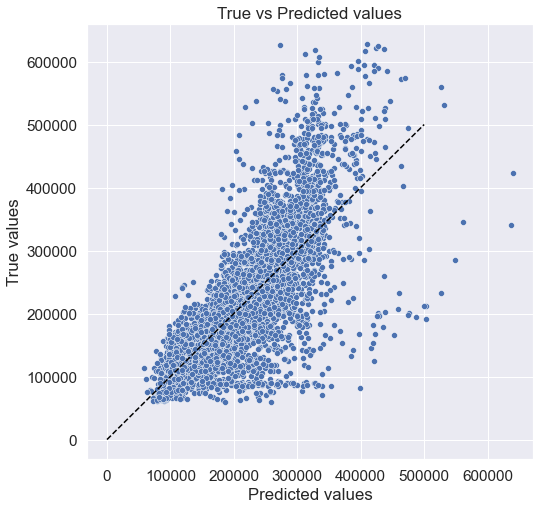

In [339]:
y_train_preds = lr_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.558
RMSE:	63818.077
MSE:	4072746919.217


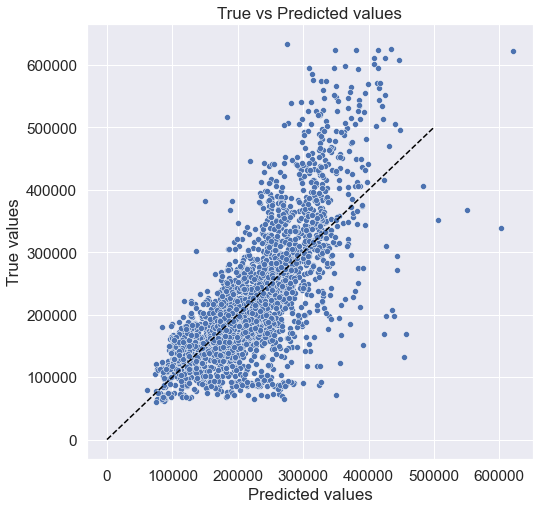

In [340]:
y_test_preds = lr_model.predict(X_valid)
evaluate_preds(y_valid, y_test_preds)

##### Random Forest Regressor

In [341]:
random_forest_regressor_model = RandomForestRegressor(criterion='mse',
                                 max_depth=20,  
                                 min_samples_leaf=30,
                                 random_state=42,
                                 n_estimators=100
                                 )
random_forest_regressor_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, min_samples_leaf=30, random_state=42)

R2:	0.708
RMSE:	49305.66
MSE:	2431048063.707


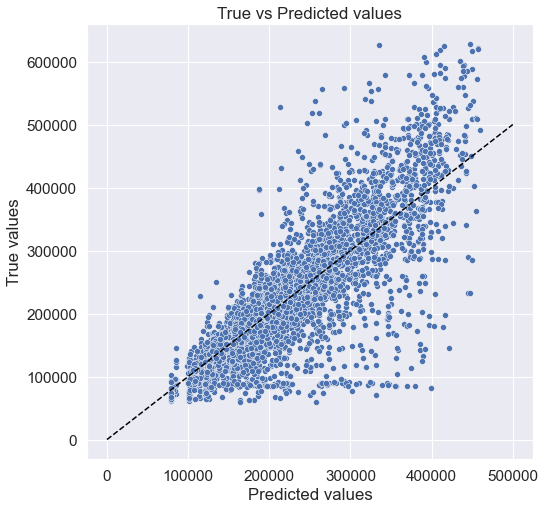

In [342]:
y_train_preds = random_forest_regressor_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.676
RMSE:	54627.394
MSE:	2984152218.632


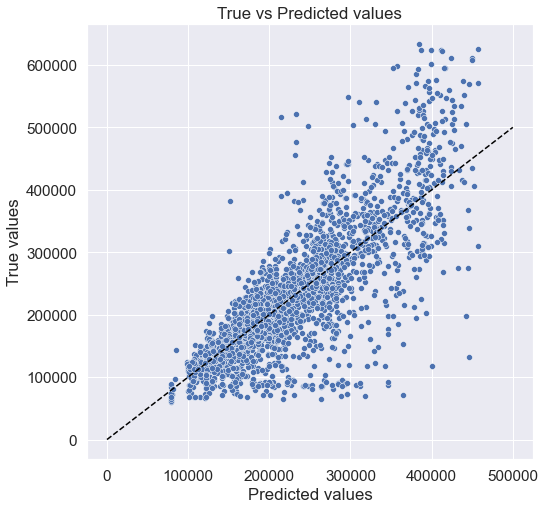

In [343]:
y_test_preds = random_forest_regressor_model.predict(X_valid)
evaluate_preds(y_valid, y_test_preds)

##### Gradient Boosting Regressor

In [344]:
gradient_boosting_regressor_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=7,
                                     min_samples_leaf=10,
                                     random_state=42,  
                                     n_estimators=100)

gradient_boosting_regressor_model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', max_depth=7, min_samples_leaf=10,
                          random_state=42)

R2:	0.873
RMSE:	32487.823
MSE:	1055458617.099


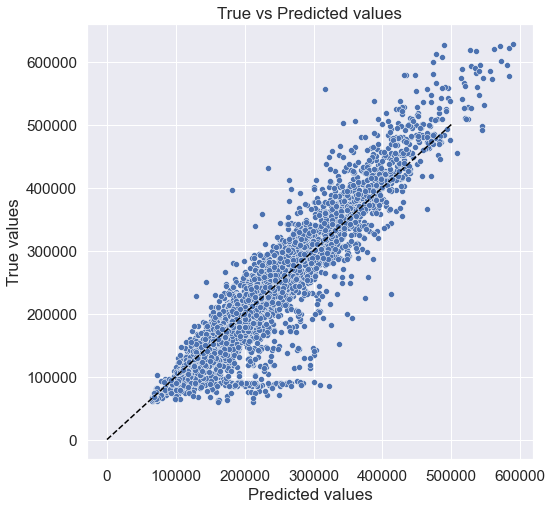

In [345]:
y_train_preds = gradient_boosting_regressor_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.714
RMSE:	51337.401
MSE:	2635528697.596


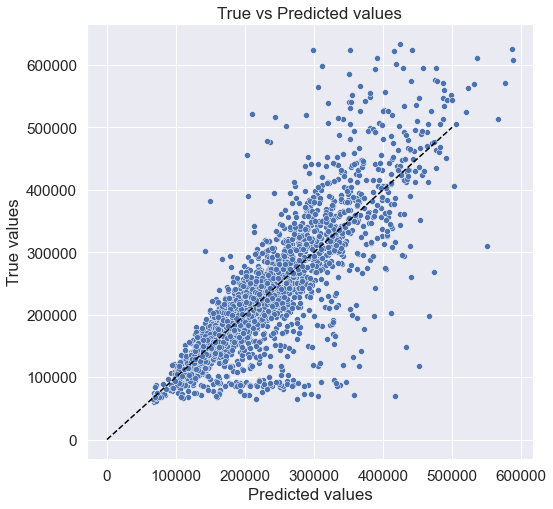

In [346]:
y_test_preds = gradient_boosting_regressor_model.predict(X_valid)
evaluate_preds(y_valid, y_test_preds)

##### LGBMRegressor

In [347]:
!pip install lightgbm
from lightgbm import LGBMRegressor

In [348]:
lgbm_regressor_model = LGBMRegressor()
lgbm_regressor_model.fit(X_train, y_train)

LGBMRegressor()

R2:	0.84
RMSE:	36498.293
MSE:	1332125368.036


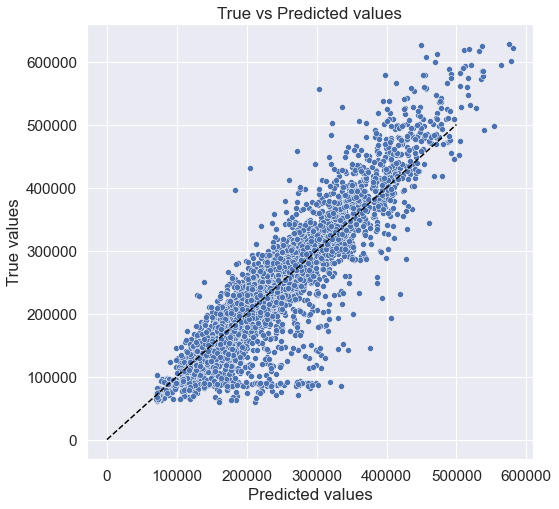

In [349]:
y_train_preds = lgbm_regressor_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.716
RMSE:	51116.208
MSE:	2612866669.631


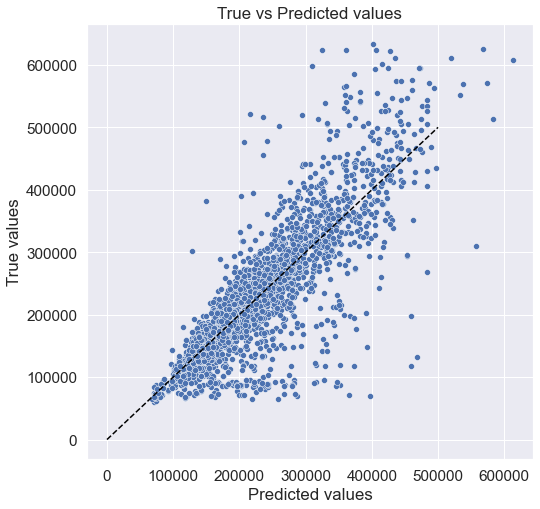

In [350]:
y_test_preds = lgbm_regressor_model.predict(X_valid)
evaluate_preds(y_valid, y_test_preds)

LGBMR Tune

    lgbm_regressor_model.get_params()

    parameters = [{
        'max_bin': np.arange(90, 120, 10),
        'n_estimators': np.arange(4000, 7000, 1000),
        'learning_rate': np.arange(0.01, 0.05, 0.01)
    }]

    clf = GridSearchCV(
        estimator=LGBMRegressor(random_state=42),
        param_grid=parameters,
        scoring='neg_mean_squared_error',
        cv=4,
        n_jobs=-1,
    )

    clf.fit(X_train, y_train)

    clf.best_params_

In [351]:
lgbm_regressor_model = LGBMRegressor(
    max_bin=90,
    num_leaves=4,
    n_estimators=4000,
    learning_rate=0.01
)
lgbm_regressor_model.fit(X_train, y_train)

LGBMRegressor(learning_rate=0.01, max_bin=90, n_estimators=4000, num_leaves=4)

R2:	0.752
RMSE:	45481.855
MSE:	2068599148.177


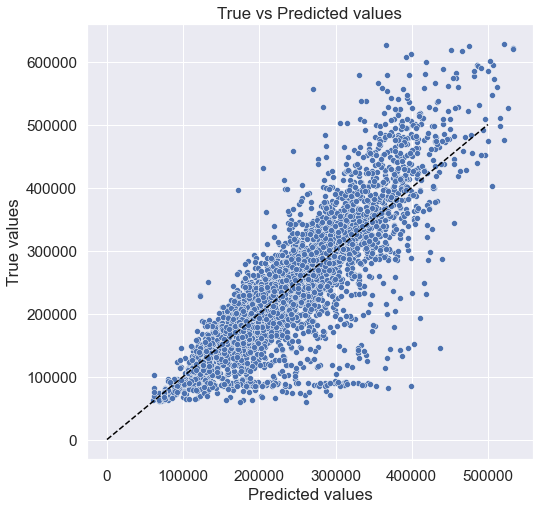

In [352]:
y_train_preds = lgbm_regressor_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.704
RMSE:	52235.895
MSE:	2728588692.688


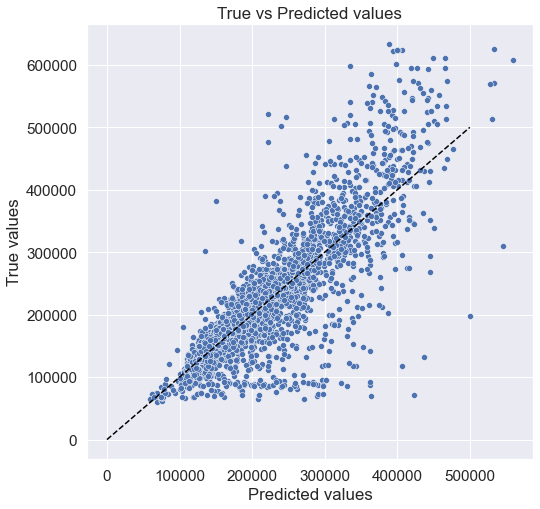

In [353]:
y_test_preds = lgbm_regressor_model.predict(X_valid)
evaluate_preds(y_valid, y_test_preds)

### Прогноз на тестовом датасете

In [354]:
predictions = lgbm_regressor_model.predict(test_df)
predictions

array([165200.20236484, 127925.70763969, 151241.82782077, ...,
       149405.92333935, 187597.03616844, 255380.75036701])

In [355]:
submit = pd.read_csv('./real-estate-price-prediction-moscow/sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [356]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,165200.202365
1,5925,127925.707640
2,960,151241.827821
3,3848,137991.615216
4,746,198683.642436


In [357]:
submit.to_csv('NekrasovaLO_predictions.csv', index=False)